```markdown
To run this Jupyter notebook, use Python 3.13 or later. The recommended environment is a virtual environment or a conda environment with the necessary packages installed, as specified int he requirements.txt file. Ensure that you have Jupyter Notebook installed to execute the cells interactively.
```

In [10]:
%pip install nbformat

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached fastjsonschema-2.21.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached attrs-24.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached referencing-0.35.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached rpds_py-0.22.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (4.2 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Using cached fastjsonschema-2.21.1-py3-none-any.whl (23 kB)
Using cached jsonschema-4.23.0-py3-none-any.whl (88 kB)
Using cached attrs-24.2.0-py3-none-any.whl (63 kB)
Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl (18 kB)
Using cached referencing-0.35.1-py3-none-any.whl (26 kB)
Using cached rpds_py-0.22.0-cp313-cp313-macosx_11_0_arm64.whl (345 kB)
Note: you may need to restart the kernel to use updated packages.


### Install Required Packages

In [11]:
%run installrequirements.ipynb

Note: you may need to restart the kernel to use updated packages.


<IPython.core.display.Javascript object>

### Import Reusable Code

In [12]:
%run reuse.ipynb

In [13]:
import ipywidgets as widgets
from IPython.display import display

# Create a dropdown widget for environment selection
env_dropdown = widgets.Dropdown(
    options=['dev', 'uat', 'prod'],
    value='dev',
    description='Environment:',
)

outputdirectory = widgets.Text("testdata")

# Display the widget
display(widgets.HBox([env_dropdown, outputdirectory]))




In [14]:
selected_env = env_dropdown.value
outputdir = outputdirectory.value
healthData = HealthData(selected_env,outputdir) # type: ignore
healthData.generate_data()

In [15]:
import pandas as pd

healthdatadf = pd.read_parquet(f"./{outputdir}/health_data_{selected_env}.parquet")

In [16]:
####!pyspark --packages io.delta:delta-core_2.11:0.4.0
import pyspark
from pyspark.sql import SparkSession
from delta import *


builder = (
    SparkSession.builder.appName("DeltaTableCreation_new")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)


In [17]:
filtered_healthdatadf = healthdatadf[healthdatadf['BloodPressure'] > 120]
print(filtered_healthdatadf)

# Use Spark SQL to filter the data and convert to Pandas DataFrame
spark.createDataFrame(healthdatadf).createOrReplaceTempView("sparkhealthdatadf")
filtered_healthdatadf_sql = spark.sql("SELECT * FROM sparkhealthdatadf WHERE BloodPressure > 120").toPandas()
print(filtered_healthdatadf_sql)

    PatientID  Age  Height  Weight  BloodPressure
0           1   64     161      95            161
2           3   73     156      66            171
5           6   79     153      71            128
7           8   59     186      75            147
14         15   26     165      56            173
15         16   44     163      71            164
17         18   32     198      63            149
19         20   21     155      74            124
20         21   58     191      65            146
21         22   59     185      91            171
22         23   43     150      68            165
25         26   37     180      61            155
29         30   28     184      51            150
30         31   29     198      81            151
32         33   71     153      74            172
33         34   36     184      74            123
34         35   71     192      53            163
35         36   25     163      68            129
36         37   35     198      97            121


In [18]:
# Create a Spark DataFrame from the healthdatadf DataFrame
sparkdf = spark.createDataFrame(healthdatadf)

# Write the DataFrame as a Delta table
sparkdf.write.format("delta").mode("overwrite").save(f"./{outputdir}/health_data_{selected_env}")

24/12/02 15:03:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/12/02 15:03:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
24/12/02 15:03:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
24/12/02 15:03:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
24/12/02 15:03:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 63.33% for 12 writers
24/12/02 15:03:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
24/12/02 15:03:02 WARN MemoryManager: Total allocation exceeds 95.

In [19]:
# Read the Delta table
delta_table = spark.read.format("delta").load(f"./{outputdir}/health_data_{selected_env}")

filtered_data = delta_table.filter(delta_table.BloodPressure > 120)
filtered_data.show()

+---------+---+------+------+-------------+
|PatientID|Age|Height|Weight|BloodPressure|
+---------+---+------+------+-------------+
|        1| 64|   161|    95|          161|
|        3| 73|   156|    66|          171|
|        6| 79|   153|    71|          128|
|        8| 59|   186|    75|          147|
|       84| 61|   190|    71|          162|
|       85| 77|   158|    83|          148|
|       87| 58|   181|    84|          179|
|       88| 75|   158|    84|          163|
|       90| 66|   152|    83|          152|
|       91| 38|   153|    55|          141|
|       51| 21|   196|    60|          143|
|       54| 52|   167|    78|          174|
|       56| 30|   164|    90|          143|
|       57| 72|   191|    52|          147|
|       58| 43|   151|    77|          131|
|       15| 26|   165|    56|          173|
|       16| 44|   163|    71|          164|
|       34| 36|   184|    74|          123|
|       35| 71|   192|    53|          163|
|       36| 25|   163|    68|   

In [20]:
# Create a temporary view
delta_table.createOrReplaceTempView(f"health_data")

# Use Spark SQL to filter the data
filtered_data_sql = spark.sql("SELECT * FROM health_data WHERE BloodPressure > 120")
filtered_data_sql.show()

+---------+---+------+------+-------------+
|PatientID|Age|Height|Weight|BloodPressure|
+---------+---+------+------+-------------+
|        1| 64|   161|    95|          161|
|        3| 73|   156|    66|          171|
|        6| 79|   153|    71|          128|
|        8| 59|   186|    75|          147|
|       84| 61|   190|    71|          162|
|       85| 77|   158|    83|          148|
|       87| 58|   181|    84|          179|
|       88| 75|   158|    84|          163|
|       90| 66|   152|    83|          152|
|       91| 38|   153|    55|          141|
|       51| 21|   196|    60|          143|
|       54| 52|   167|    78|          174|
|       56| 30|   164|    90|          143|
|       57| 72|   191|    52|          147|
|       58| 43|   151|    77|          131|
|       15| 26|   165|    56|          173|
|       16| 44|   163|    71|          164|
|       34| 36|   184|    74|          123|
|       35| 71|   192|    53|          163|
|       36| 25|   163|    68|   

In [21]:
# Execute the SQL query and display the results
result = spark.sql("SELECT * FROM `parquet`.`./testdata/health_data_dev` WHERE BloodPressure > 120")
result.show()

+---------+---+------+------+-------------+
|PatientID|Age|Height|Weight|BloodPressure|
+---------+---+------+------+-------------+
|        1| 64|   161|    95|          161|
|        3| 73|   156|    66|          171|
|        6| 79|   153|    71|          128|
|        8| 59|   186|    75|          147|
|        1| 64|   161|    95|          161|
|        3| 73|   156|    66|          171|
|        6| 79|   153|    71|          128|
|        8| 59|   186|    75|          147|
|        1| 64|   161|    95|          161|
|        3| 73|   156|    66|          171|
|        6| 79|   153|    71|          128|
|        8| 59|   186|    75|          147|
|       84| 61|   190|    71|          162|
|       85| 77|   158|    83|          148|
|       87| 58|   181|    84|          179|
|       88| 75|   158|    84|          163|
|       90| 66|   152|    83|          152|
|       91| 38|   153|    55|          141|
|       84| 61|   190|    71|          162|
|       85| 77|   158|    83|   

In [22]:
import os

# List all files in the subfolders of the testdata directory
file_list = [os.path.join(root, file) for root, dirs, files in os.walk(outputdir) for file in files if file.endswith('.csv') or file.endswith('.parquet')]

# Create a dropdown widget for file selection
file_dropdown = widgets.Dropdown(
    options=[file.replace('testdata/', '') for file in file_list],
    description='Files:',
)

# Display the widget
display(file_dropdown)


Dropdown(description='Files:', options=('health_data_prod.parquet', 'health_data_uat.parquet', 'health_data_de…

In [28]:
file_extension= file_dropdown.value.split('.')[-1]

spark.sql(f"SELECT * FROM `{file_extension}`.`./{outputdir}/{file_dropdown.value}`").show()


+---------+---+------+------+-------------+
|PatientID|Age|Height|Weight|BloodPressure|
+---------+---+------+------+-------------+
|       17| 44|   171|    81|           82|
|       18| 32|   198|    63|          149|
|       19| 78|   199|    57|           92|
|       20| 21|   155|    74|          124|
|       21| 58|   191|    65|          146|
|       22| 59|   185|    91|          171|
|       23| 43|   150|    68|          165|
|       24| 66|   181|    90|          119|
|       25| 44|   155|    65|          119|
+---------+---+------+------+-------------+



In [29]:
# List columns and data types
sparkdf.printSchema()

root
 |-- PatientID: long (nullable = true)
 |-- Age: long (nullable = true)
 |-- Height: long (nullable = true)
 |-- Weight: long (nullable = true)
 |-- BloodPressure: long (nullable = true)



In [32]:
# Describe the data
display(sparkdf.describe().show())

+-------+------------------+------------------+-----------------+-----------------+------------------+
|summary|         PatientID|               Age|           Height|           Weight|     BloodPressure|
+-------+------------------+------------------+-----------------+-----------------+------------------+
|  count|               100|               100|              100|              100|               100|
|   mean|              50.5|             48.62|           173.29|            74.91|            131.52|
| stddev|29.011491975882016|18.117896727219243|15.59804118756227|14.04544931515708|29.495241869313315|
|    min|                 1|                20|              150|               50|                80|
|    max|               100|                79|              199|               97|               179|
+-------+------------------+------------------+-----------------+-----------------+------------------+



None

In [33]:

if '/' in file_dropdown.value:
	database_name = file_dropdown.value.split('/')[0].replace('-', '') if file_dropdown.value.split('/')[0] else 'TestDB'
	table_name = file_dropdown.value.split('/')[1].split('.')[0].replace('_', '')
else:
	database_name = 'TestDB'
	table_name = file_dropdown.value.split('.')[0].replace('_', '')




In [38]:
sparkdf = spark.read.format(f"{file_extension}").option("header", "true").load(f"./{outputdir}/{file_dropdown.value}")

# Rename columns to remove invalid characters
for col in sparkdf.columns:
	new_col = col.replace(' ', '_').replace('(', '').replace(')', '').replace('\n', '').replace('\t', '').replace('=', '')
	sparkdf = sparkdf.withColumnRenamed(col, new_col)

# Create a database
spark.sql(f"CREATE DATABASE IF NOT EXISTS {database_name}")

# Use the created database
spark.sql(f"USE {database_name}")

table_name = table_name.replace(' ', '_').replace('(', '').replace(')', '').replace('\n', '').replace('\t', '').replace('=', '').replace('-', '')

# Write the DataFrame as a Delta table in the created database
sparkdf.write.format("delta").mode("overwrite").saveAsTable(f"{table_name}")

# Verify that the table has been created and data has been loaded


In [39]:
spark.sql("SHOW TABLES").show()



+---------------+--------------------+-----------+
|      namespace|           tableName|isTemporary|
+---------------+--------------------+-----------+
|health_data_dev|part00002f16d5588...|      false|
|               |         health_data|      false|
|               |   sparkhealthdatadf|      false|
+---------------+--------------------+-----------+



+--------+
|count(1)|
+--------+
|       9|
+--------+



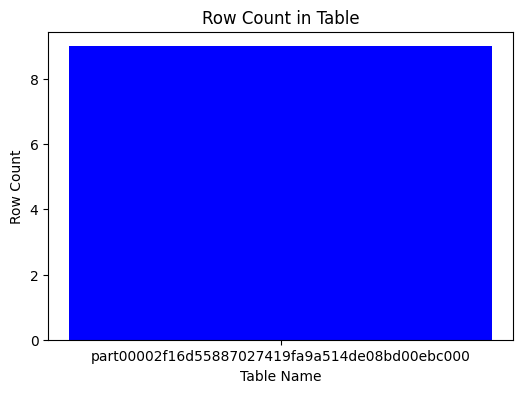

In [43]:
spark.sql(f"SELECT COUNT(*) FROM {table_name}").show()
import matplotlib.pyplot as plt

# Get the count of rows in the table
count = spark.sql(f"SELECT COUNT(*) as count FROM {table_name}").collect()[0]['count']

# Plot the count
plt.figure(figsize=(6, 4))
plt.bar([table_name], [count], color='blue')
plt.xlabel('Table Name')
plt.ylabel('Row Count')
plt.title('Row Count in Table')
plt.show()


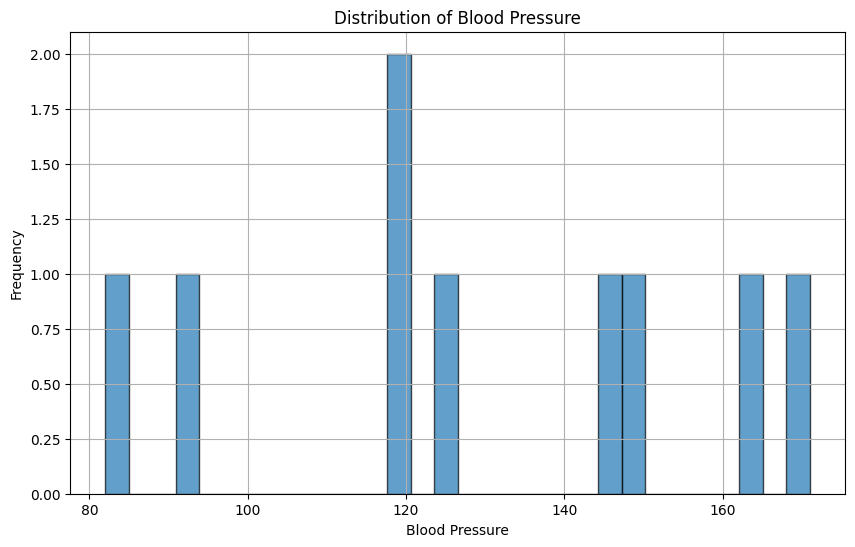

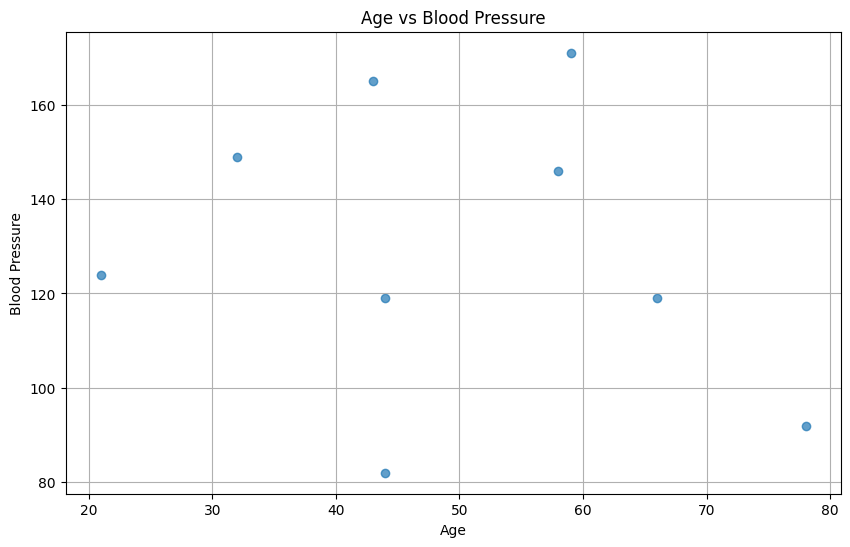

In [44]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df = sparkdf.toPandas()

# Plot the distribution of BloodPressure
plt.figure(figsize=(10, 6))
plt.hist(pandas_df['BloodPressure'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Blood Pressure')
plt.xlabel('Blood Pressure')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot Age vs BloodPressure
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['Age'], pandas_df['BloodPressure'], alpha=0.7)
plt.title('Age vs Blood Pressure')
plt.xlabel('Age')
plt.ylabel('Blood Pressure')
plt.grid(True)
plt.show()